<a href="https://colab.research.google.com/github/haoran-zh/TransformerTrack-Colab_version/blob/main/TransformerTrack_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# connect google drive
# by running this, you can connect your code with your google drive.
# Upload your project files to your google drive in advance, then you can connect it with your code by running this.
from google.colab import drive
drive.mount('/content/drive') # the path where the drive is connected

# change the work directory
%cd /content/drive/MyDrive/TUMresearch

# check the work directory
!pwd

Mounted at /content/drive
/content/drive/MyDrive/TUMresearch
/content/drive/MyDrive/TUMresearch


In [ ]:
# detect GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# Tracker Model Preparation
1. Change working path.
2. Install necessary environments

In [ ]:
%cd /content/drive/MyDrive/TUMresearch

/content/drive/MyDrive/TUMresearch


In [ ]:
%cd TransformerTrack
# !git submodule update --init
!bash install.sh conda_install_path pytracking
!pip install lvis
!pip install ipywidgets
!apt-get update
!apt-get install -y xvfb

# Training and testing

In [ ]:
%cd ltr

/content/drive/MyDrive/TUMresearch/TransformerTrack/ltr


In [ ]:
# fine-tune the pretrained model
import datetime
from google.colab import runtime

current_time = datetime.datetime.now()
print("Current time:", current_time)

!python run_training.py dimp transformer_dimp_ultrasound | tee ../../train_log.txt

current_time = datetime.datetime.now()
print("End time:", current_time)

runtime.unassign() # end the session after the training

In [ ]:
!pwd | tee ../../train_log.txt

/content


In [ ]:
import datetime
current_time = datetime.datetime.now()
print("Current time:", current_time)

Current time: 2023-05-31 22:11:06.984846


In [ ]:
%cd TransformerTrack/pytracking

/content/drive/MyDrive/TUMresearch/TransformerTrack/pytracking


In [ ]:
# test
# Create a virtual display to run the code in headless version
import subprocess
xvfb = subprocess.Popen(["Xvfb", ":99"])
import os
os.environ['DISPLAY'] = ':99'

!python run_video.py trdimp trdimp ../before0514/c_zhongliang_1.avi --optional_box 570 230 130 125 --debug 0 --save_results

xvfb.terminate() # end that
# x(top left) y(top left) w h

# p_yuanbi_2      470 182 120 125
# p_arm_5s_20_zl  345 228 60  62
# c_zhongliang_1  570 230 130 125
# c_arm_1_zl      320 225 60  60


# output_origin_1 540 160 130 125
# output_origin_2 460 150 130 140
# output_origin_4 420 190 130 140
# output_origin_7 450 240 130 140

# test_video 484 221 121 108

Using /root/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu118/_prroi_pooling/build.ninja...
Building extension module _prroi_pooling...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module _prroi_pooling...


# Show the result
add box on the original video

In [ ]:
!pwd

/content/drive/MyDrive/TUMresearch/TransformerTrack/pytracking


In [ ]:
# working path:
# Have the result of boxing.
import io
import base64
from IPython.display import HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import cv2
import os
from google.colab.patches import cv2_imshow # replace cv2.imshow()

def add_box(video_cv2, box_path):
  box_file = open(box_path, 'rb')
  box_text = box_file.readlines()

  box_text = [x.strip() for x in box_text] # remove '\n'
  box_list = []
  for line in box_text:
    row = line.split(bytes('\t', 'utf-8')) # remove '\t'
    row = [int(row_byte) for row_byte in row]
    box_list.append(row) # the box is like x y w h

  # Create output video writer
  frame_width = int(video_cv2.get(cv2.CAP_PROP_FRAME_WIDTH))
  frame_height = int(video_cv2.get(cv2.CAP_PROP_FRAME_HEIGHT))
  fps = int(video_cv2.get(cv2.CAP_PROP_FPS))
  fourcc = cv2.VideoWriter_fourcc(*'MJPG')
  out = cv2.VideoWriter('../output_'+option[0:-4]+'.avi', fourcc, fps, (frame_width, frame_height))

  # process the video
  frame_index = 0
  while video_cv2.isOpened():
    ret, frame = video_cv2.read()
    if ret is False:
      break
    else:
      x_tl = box_list[frame_index][0]
      y_tl = box_list[frame_index][1]
      x_br = x_tl + box_list[frame_index][2]
      y_br = y_tl + box_list[frame_index][3]
      cv2.rectangle(frame, (x_tl, y_tl), (x_br, y_br), (0, 255, 0), 2)
      out.write(frame)
      frame_index += 1
      # cv2_imshow(frame)

  out.release()
  box_file.close()
  return 0



# Read the video file
# video_file = open('../original.avi', 'rb')
# video_bytes = video_file.read()

option = 'c_zhongliang_1.avi'
fv_path = os.path.join('../before0514', option)
video_cv2 = cv2.VideoCapture(fv_path)

frame_width = int(video_cv2.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_cv2.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video_cv2.get(cv2.CAP_PROP_FPS))

video_boxed = add_box(video_cv2, box_path = 'tracking_results/trdimp/trdimp/video_'+option[0:-4]+'.txt')

# get the output_video
output_file = open('../output_'+option, 'rb')
output_bytes = output_file.read()

# Create the video player widget
video_widget = widgets.Video(
    value=output_bytes,
    format='avi',
    width=frame_width,
    height=frame_height,
    autoplay=True,
    loop=True
)

# Display the video player widget
video_cv2.release()
output_file.close()
# display(video_widget)

# Ultrasound Dataset re-organize
We want to follow the structure of GOT10k dataset, and re-organize our ultrasound dataset just like it.

The structure is like:

-root  
----folder_video1   
--------img1.png  
--------img2.png  
--------img3.png  
--------groundtruth.txt  
----folder_video2  
--------xxxx  
----folder_video3   
--------xxxx  
----list.txt(contain all folders' name)  

In [ ]:
import shutil
import os
for i in range(105):
  shutil.copy('val_data/val/GOT-10k_Val_000002/meta_info.ini', os.path.join('ultrasound_dataset', str(i), 'meta_info.ini'))
  #shutil.copy('val_data/val/GOT-10k_Val_000002/cover.label', os.path.join('ultrasound_dataset', str(i), 'cover.label'))
  #shutil.copy('val_data/val/GOT-10k_Val_000002/cut_by_image.label', os.path.join('ultrasound_dataset', str(i), 'cut_by_image.label'))

In [ ]:
# re organize the dataset
import os
import shutil
import cv2
import numpy as np

def extract_number(string):
  return int(''.join(filter(str.isdigit, string)))


def seg2box(label): # np.array
  label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
  find = np.argwhere(label==1)
  # print(label.shape) # (656, 832) y x
  # when create video, 832 656(w h)
  # imread().shape is h w, correspond to y x
  # [209y 473x] [168y 519x]
  # [212y 577x] [266y 517x]
  x_min = min(find, key=lambda x: x[1])[1] # [209y 473x]
  y_min = min(find, key=lambda x: x[0])[0] # [168y 519x]
  x_max = max(find, key=lambda x: x[1])[1] # [212y 577x]
  y_max = max(find, key=lambda x: x[0])[0] # [266y 517x]
  width = x_max - x_min
  height = y_max - y_min
  box = str(x_min)+'\t'+str(y_min)+'\t'+str(width)+'\t'+str(height) # xmin, ymin, width, height
  return box


split_size = 90
current_path = !pwd
current_path = current_path[0]
assert current_path[-11:] == 'TUMresearch', 'current path wrong'
work_path = os.path.join(current_path, 'us_data_with_label')
result_path = os.path.join(current_path, 'ultrasound_dataset')

folders = os.listdir(work_path)
# 可以舍弃最后几个，保证完整性
tiny_video_num = 0
for folder in folders:
  print('folder num:', folder)
  try:
    ground_truth_file.close()
    print('extra frames come into tiny tiny videos')
  except:
    print('everything is fine')
  folder_path = os.path.join(work_path, folder)
  img_path = os.path.join(folder_path, 'img')
  label_path = os.path.join(folder_path, 'label')
  img_list = os.listdir(img_path)
  label_list = os.listdir(label_path)
  img_list_sorted = sorted(img_list, key=extract_number)
  label_list_sorted = sorted(label_list, key=extract_number)
  # tiny videos
  dest_path = os.path.join(result_path, str(tiny_video_num)) # the dest folder path
  try:
    os.makedirs(dest_path)
  except:
    print('dest_path already exist')
  ground_truth_file = open(os.path.join(dest_path, 'groundtruth.txt'), 'w')
  frame_num = 0
  for (img, label) in zip(img_list_sorted, label_list_sorted):
    shutil.copy(os.path.join(img_path, img), os.path.join(dest_path, str(frame_num)+'.png'))
    # get label box
    label_mask = cv2.imread(os.path.join(label_path, label))
    box = seg2box(label_mask)# xmin ymin width height
    ground_truth_file.write(box+'\n')
    frame_num += 1
    if frame_num > split_size:
      print('tiny video num:', str(tiny_video_num))
      frame_num = 0
      # save current, create a new folder
      # save txt
      ground_truth_file.close()
      # reset dest_path
      tiny_video_num += 1
      dest_path = os.path.join(result_path, str(tiny_video_num))
      try:
        os.makedirs(dest_path)
      except:
        print('dest_path already exist')
      ground_truth_file = open(os.path.join(dest_path, 'groundtruth.txt'), 'w')

In [ ]:
%cd ../../

/content/drive/MyDrive/TUMresearch


In [ ]:
# convert the dataset from png to jpg
from PIL import Image
import os

def convert_png_to_jpg(png_folder, jpg_folder):
    for filename in os.listdir(png_folder):
        if filename.endswith('.png'):
            png_path = os.path.join(png_folder, filename)
            jpg_path = os.path.join(jpg_folder, os.path.splitext(filename)[0] + '.jpg')

            # Open the PNG image
            image = Image.open(png_path)

            # Convert PNG to JPEG
            image.convert('RGB').save(jpg_path, 'JPEG')

            # Delete the PNG file
            os.remove(png_path)

            print(f"Converted {png_path} to {jpg_path} and deleted {png_path}")


# Specify the folder paths
png_folder = 'ultrasound_dataset/'
jpg_folder = 'ultrasound_dataset/'

# Call the conversion function
for i in range(1, 105):
  p_folder = png_folder + str(i)
  j_folder = jpg_folder + str(i)
  convert_png_to_jpg(p_folder, j_folder)


In [ ]:
# create a cut for boxing position with pickle data.
import pickle
import numpy as np
import cv2
# From pickle to video
data_path = '../us_data/c_arm_1_zl/tmp_0.pickle'
data_all = pickle.load(open(data_path, 'rb'))  # Dict('ee_poses':xxx, 'us_images':xxx)
data_image = data_all['us_images']  # list(each frame)
data_array  = np.array(data_image)
print(data_array.shape)
p = data_array
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
writer = cv2.VideoWriter("cut.avi", fourcc, 30, (p.shape[2], p.shape[1]), 0)
for i in range(0,p.shape[0]):
    writer.write(cv2.convertScaleAbs(p[i]))
writer.release()

# play_video('cut.avi', p.shape[2], p.shape[1])

(30, 657, 837)


# Process video. create all-together video. (pickle file)

In [ ]:
%cd TransformerTrack/pytracking

/content/drive/MyDrive/TUMresearch/TransformerTrack/pytracking


In [ ]:
# Combine all videos together and try to track them all at once.
import cv2
import os
import pickle
import numpy as np


def get_info(pickle_path):
  with open(pickle_path, 'rb') as target_file:
    data = pickle.load(target_file)
    images = data['us_images']
    length = len(images) # frame length
    height, width = images[0].shape
  return length, width, height


def play_video(video_path, width, height):
  with open(video_path, 'rb') as output_file:
    output_bytes = output_file.read()
    # Create the video player widget
  video_widget = widgets.Video(
      value=output_bytes,
      format='avi',
      width=width,
      height=height,
      autoplay=True,
      loop=True
  )
  # Display the video player widget
  display(video_widget)


option = 'p_yuanbi_2'
dataset = '../../us_data'
folder_path = os.path.join(dataset, option)
file_names = os.listdir(folder_path)

# load one sample to get frame_width and frame_height information
sample_path = os.path.join(folder_path, file_names[0])
frame_num, width, height = get_info(sample_path)
fps = frame_num

# create the output video
out_path = '../' + option + '.avi'
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter(out_path, fourcc, fps, (width, height), 0)


for file_name in file_names:
  file_path = os.path.join(folder_path, file_name)
  with open(file_path, "rb") as pickle_file:
    data = pickle.load(pickle_file) # nFrames x image_height x image_width
    us_images = data['us_images'] # us_images is a list. each item is a frame (np.array). each file stores 1 second images.
    for frame in us_images:
      out.write(cv2.convertScaleAbs(frame))

out.release()
# play_video(out_path, width, height)


In [ ]:
import cv2
import os

import pickle
# Open video file

folder_path = '../../us_data/c_arm_1_zl'
file_names = os.listdir(folder_path)

for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    video = cv2.VideoCapture(file_path)
    while video.isOpened():
      ret, frame = video.read()
      if ret is False:
        break
      else:
        out.write(frame)


    with open(file_path, "r") as file:
        # Do something with the file contents here
        pass






frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video.get(cv2.CAP_PROP_FPS))
print(frame_width, frame_height, fps)

# Process the data, create all-together videos. (1 2 4 7)

In [ ]:
%cd ..

/content/drive/MyDrive/TUMresearch


In [ ]:
# fuse the image folder 66 into a video. should feasible for any other folders.

import os
import numpy as np
import cv2

# current work path = TUMresearch

# folder_path = TUMresearch/test_data/xxx.jpg...

# 1. get the folder_path and img paths.

# 2. read the image one by one sortedly and create the video.

# put the video into run_video.py, get the txt file to show the box result

# compare the predict box and ground truth box.

def extract_number(string):
  return int(''.join(filter(str.isdigit, string)))

dataset_folder = 'test_data'
jpg_files = [file_name for file_name in os.listdir(dataset_folder) if file_name.endswith(".jpg")]
sorted_files = sorted(jpg_files, key=extract_number)

out_origin_file = "test_video.avi"
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out_origin = cv2.VideoWriter(out_origin_file, fourcc, 30, (832, 656)) # 832 is the width

for file_name in sorted_files:
  # assert file_name[3:7] == label_file_name[5:9], "Image and Label failed in matching"
  img = cv2.imread(os.path.join(dataset_folder, file_name))
  # print('image shape', img.shape) # 656 832 3
  # print('label shape', label.shape) # 656 832
  out_origin.write(img)

out_origin.release()



In [ ]:
# Process the us_data with label， create all-sum videos.
# for the original folder, 1 2 4 7
# work path: /content/drive/MyDrive/TUMresearch
import os
import numpy as np
import cv2


def extract_number(string):
  return int(''.join(filter(str.isdigit, string)))


def t(ot):
  option = ot
  # option 1 2 4 7
  dataset_name = 'us_data_with_label'
  folder_name = os.path.join(dataset_name, option, 'img')
  label_folder_name = os.path.join(dataset_name, option, 'label')
  file_names = os.listdir(folder_name)
  label_file_names = os.listdir(label_folder_name)


  # Define the output video file and video writer
  out_label_file = "output_labeled_"+option+".avi"
  fourcc = cv2.VideoWriter_fourcc(*'MJPG')
  out_label = cv2.VideoWriter(out_label_file, fourcc, 30, (832, 656)) # 832 is the width

  out_origin_file = "output_origin_"+option+'.avi'
  fourcc = cv2.VideoWriter_fourcc(*'MJPG')
  out_origin = cv2.VideoWriter(out_origin_file, fourcc, 30, (832, 656)) # 832 is the width


  # sort the file name list
  sorted_files = sorted(file_names, key=extract_number)
  sorted_label_files = sorted(label_file_names, key=extract_number)


  for (file_name, label_file_name) in zip(sorted_files, sorted_label_files):
    # assert file_name[3:7] == label_file_name[5:9], "Image and Label failed in matching"
    img = cv2.imread(os.path.join(folder_name, file_name))
    # print('image shape', img.shape) # 656 832 3
    label = cv2.imread(os.path.join(label_folder_name, label_file_name))
    label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
    # print('label shape', label.shape) # 656 832
    labeled_img = np.copy(img)
    labeled_img[label == 1] = [255, 0, 0]
    out_label.write(labeled_img)
    out_origin.write(img)

  out_label.release()
  out_origin.release()

t('7')

# 1-d signal plot

In [ ]:
%cd /content/drive/MyDrive/TUMresearch

/content/drive/MyDrive/TUMresearch


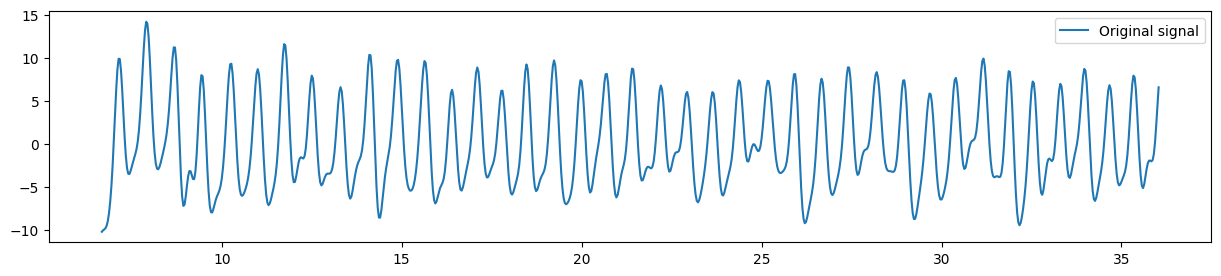

In [ ]:
# evaluate the performance of the tracker

# read the video with label
# calculate the area of the label part
# draw a plot for that

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import math

def read_box_text(file_name):
  box_path = file_name
  box_file = open(box_path, 'rb')
  box_text = box_file.readlines()

  box_text = [x.strip() for x in box_text] # remove '\n'
  box_list = []
  for line in box_text:
    row = line.split(bytes('\t', 'utf-8')) # remove '\t'
    row = [int(row_byte) for row_byte in row]
    box_list.append(row) # the box is like x y w h
  return box_list

def butter_bandpass(lowcut, highcut, fs, order=5):
  return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
  b, a = butter_bandpass(lowcut, highcut, fs, order=order)
  y = lfilter(b, a, data)
  return y

# current work path: pytracking

def estimate_diameter(frame):
  # get the area of the label
  # get the estimated diameter by np.pi * (d/2)**2 = area
  # return the estimated diameter
  label_corr = np.argwhere(np.not_equal(frame[...,0], frame[...,1]))
  sum = label_corr.shape[0]
  d = math.sqrt(sum/math.pi)
  return d

def area_evaluation(path, length):
  # 1. read the video
  video_cv2 = cv2.VideoCapture(path)
  frame_length = length
  sum_list = []
  ini = 0
  assert video_cv2.isOpened(), 'Failed to open the video'
  # 2. calculate the area
  while video_cv2.isOpened():
    ini += 1
    ret, frame = video_cv2.read()
    if ret is False:
      break
    label_corr = np.argwhere(np.not_equal(frame[..., 0], frame[..., 1]))
    sum = label_corr.shape[0]
    # sum, = frame[frame==[255, 0, 0]].shape # pointer?
    sum_list.append(sum)
    if ini > frame_length:
      break
  # 3. create a time list
  time_list = []
  sampling_time = 1/30 # FPS
  for i in range(len(sum_list)):
    time_list.append(i*sampling_time)
  return sum_list, time_list


def diameter_evaluation(path, length):
  # 1. read the video
  video_cv2 = cv2.VideoCapture(path)
  frame_length = length
  diameter_list = []
  ini = 0
  assert video_cv2.isOpened(), 'Failed to open the video'
  # 2. calculate the area
  while video_cv2.isOpened():
    ini += 1
    ret, frame = video_cv2.read()
    if ret is False:
      break
    # 2.1 estimate the diameter that fit the current label best
    diameter = estimate_diameter(frame)
    diameter_list.append(diameter)
    if ini > frame_length:
      break
  # 3. create a time list
  time_list = []
  sampling_time = 1/30 # FPS
  for i in range(len(diameter_list)):
    time_list.append(i*sampling_time)
  return diameter_list, time_list


def area_evaluation_txt(box_list):
  # 1. read the video
  sum_list = []
  ini = 0
  for b in box_list:
    sum_list.append(b[2]*b[3])
  # 3. create a time list
  time_list = []
  sampling_time = 1/30 # FPS
  for i in range(len(sum_list)):
    time_list.append(i*sampling_time)
  return sum_list, time_list


def diameter_evaluation_txt(box_list):
  diameter_list = []
  ini = 0
  for b in box_list:
    diameter_list.append(b[2]+b[3])

  # 3. create a time list
  time_list = []
  sampling_time = 1/30 # FPS
  for i in range(len(diameter_list)):
    time_list.append(i*sampling_time)
  return diameter_list, time_list


# main
model_result = 'TransformerTrack/pytracking/tracking_results/trdimp/trdimp/video_c_zhongliang_1_epoch60.txt'
ground_truth = 'test_data/groundtruth.txt'

box_list = read_box_text(model_result)

x_list, time_list = diameter_evaluation_txt(box_list)
# denoise: band-pass filter
y = butter_bandpass_filter(x_list, 0.3, 2.8, 30, order=6)
plt.figure(figsize=(15,3))
plt.plot(time_list[200:], y[200:], label='Original signal')
plt.legend()
plt.show()


# need to denoise the signal. Like, get rid of the high-frequency of the signal. Band-pass filter.

# 1. Area evaluation plot
# 2. Diameter evaluation plot: calculate the similar circle for each frame's label.
# 3. some 1-d tracker? give some standard samples of pulse signals(including the usual one and others..?)

# the data is sampled continously. Ergo, the area function could be like: F(x, t) = Pulse(t) + Position(x),
# where Pulse(t) is a period function, and Position(x) should be a very low-frequency function.

# 1-d signal evaluation. from original data folder(1 2 4 7).

In [ ]:
# Evaluate the tracker result and the label.
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import math

# 1. Make sure the box should totally contain the circle label.
# 2. There should be a stable value of box_area/circle_area. More stable means more precise.
# 3. The center point of the box and the circle should be near.
# 4.

def read_box_text(file_name):
  box_path = file_name
  box_file = open(box_path, 'rb')
  box_text = box_file.readlines()

  box_text = [x.strip() for x in box_text] # remove '\n'
  box_list = []
  for line in box_text:
    row = line.split(bytes('\t', 'utf-8')) # remove '\t'
    row = [int(row_byte) for row_byte in row]
    box_list.append(row) # the box is like x y w h
  return box_list


def all_evaluation(video_cv2, box_list):
  assert video_cv2.isOpened(), 'Failed to open the video'
  frame_num = 0
  box_area_list = []
  label_area_list = []
  ratio_list = []
  center_distance_list = []
  while video_cv2.isOpened():
    ret, frame = video_cv2.read()
    if ret is False:
      break
    current_box = box_list[frame_num] # [x, y, w, h]
    frame_num += 1
    box_area = current_box[2] * current_box[3]
    box_center = (current_box[0]+current_box[2]/2, current_box[1]+current_box[3]/2) # get a tuple (x,y)

    label_corr = np.argwhere(np.not_equal(frame[..., 0], frame[..., 1])) # all positions that inside the label
    label_area = label_corr.shape[0]
    label_center = sum(label_corr)/label_area
    temp = label_center[0]
    label_center[0] = label_center[1]
    label_center[1] = temp
    center_distance = math.sqrt((label_center[0]-box_center[0])**2+(label_center[1]-box_center[1])**2)
    ratio = box_area/label_area

    box_area_list.append(box_area)
    label_area_list.append(label_area)
    ratio_list.append(ratio)
    center_distance_list.append(center_distance)
    if frame_num > 50:
      break

  area_list = [box_area_list, label_area_list]
  return area_list, ratio_list, center_distance_list





# A question: 存储视频时发生失真，灰度的是r=b=g，其余都是label

# Read the video, read the txt result of the tracker (can be more efficient compared to read another video)
def compare_label_box(video_path, txt_path):
  video_cv2 = cv2.VideoCapture(video_path)
  box_list = read_box_text(txt_path)
  area, ratio, center_distance = all_evaluation(video_cv2, box_list)
  area_array_box = np.array(area[0])
  area_array_label = np.array(area[1])
  correlation = np.corrcoef(area_array_box, area_array_label)[0, 1]
  ratio_array = np.array(ratio)
  ratio_mean = np.mean(ratio_array)
  ratio_var = np.var(ratio_array)
  center_distance_array = np.array(center_distance)
  distance_mean = np.mean(center_distance_array)
  distance_var = np.var(center_distance_array)
  print(correlation)
  print(ratio_mean, ratio_var)
  print(distance_mean, distance_var)



# main
option = '7'
compare_label_box('../output_labeled_'+option+'.avi', 'tracking_results/trdimp/trdimp/video_output_origin_'+option+'.txt')

0.6680648267906968
1.1580271656142944 0.0029360569887257847
3.1165296063694403 2.8715198886529354


# 1-d signal evaluation.
from the output box txt.

In [ ]:
%cd ../../

/content/drive/MyDrive/TUMresearch


In [ ]:
# Evaluate the tracker result and the label.
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import math


def read_box_text(file_name):
  box_path = file_name
  box_file = open(box_path, 'rb')
  box_text = box_file.readlines()

  box_text = [x.strip() for x in box_text] # remove '\n'
  box_list = []
  for line in box_text:
    row = line.split(bytes('\t', 'utf-8')) # remove '\t'
    row = [int(row_byte) for row_byte in row]
    box_list.append(row) # the box is like x y w h
  return box_list


def evaluation(model_box, truth_box):
  model_area_list = []
  truth_area_list = []
  ratio_list = []
  center_distance_list = []

  pause_spot = 33 # 0 1 2 ... 32 33 39 40 ...

  for i in range(len(model_box)):

    if i <= pause_spot:
      t = i
    else:
      t = i + 5

    current_model_box = model_box[i] # [x, y, w, h]
    current_truth_box = truth_box[t]

    model_box_area = current_model_box[2] * current_model_box[3]
    model_box_center = (current_model_box[0]+current_model_box[2]/2, current_model_box[1]+current_model_box[3]/2) # get a tuple (x,y)

    truth_box_area = current_truth_box[2] * current_truth_box[3]
    truth_box_center = (current_truth_box[0]+current_truth_box[2]/2, current_truth_box[1]+current_truth_box[3]/2)

    center_distance = math.sqrt((truth_box_center[0]-model_box_center[0])**2+(truth_box_center[1]-model_box_center[1])**2)
    ratio = model_box_area/truth_box_area

    model_area_list.append(model_box_area)
    truth_area_list.append(truth_box_area)
    ratio_list.append(ratio)
    center_distance_list.append(center_distance)

  area_list = [model_area_list, truth_area_list]
  return area_list, ratio_list, center_distance_list


# current work path TUMresearch

model_1_result = 'TransformerTrack/pytracking/tracking_results/trdimp/trdimp/video_test_video_pretrained.txt'
model_2_result = 'TransformerTrack/pytracking/tracking_results/trdimp/trdimp/video_test_video_epoch60.txt'
ground_truth = 'test_data/groundtruth.txt'

truth_box = read_box_text(ground_truth)
model_box = read_box_text(model_2_result)
area, ratio, center_distance = evaluation(model_box, truth_box)

area_array_model = np.array(area[0])
area_array_truth = np.array(area[1])
correlation = np.corrcoef(area_array_model, area_array_truth)[0, 1]
ratio_array = np.array(ratio)
ratio_mean = np.mean(ratio_array)
ratio_var = np.var(ratio_array)
center_distance_array = np.array(center_distance)
distance_mean = np.mean(center_distance_array)
distance_var = np.var(center_distance_array)

print('correlation', correlation)
print('ratio mean and var', ratio_mean, ratio_var)
print('distance mean and var', distance_mean, distance_var)

# pretrained
# correlation 0.7646347907945616
# ratio mean and var 1.0528848433103495 0.0016338945833171076
# distance mean and var 3.615145577315292 3.6400247803990875

# epoch29
# correlation 0.7972515441562111
# ratio mean and var 0.9689619809592778 0.0012674838529734213
# distance mean and var 1.9291904919217444 1.1561310226229253

# epoch30
# correlation 0.7901425380831818
# ratio mean and var 0.9636088056526799 0.0012859830352460607
# distance mean and var 1.9702955886786249 1.1179352932335507

# epoch40
# correlation 0.804700609484661
# ratio mean and var 0.9663609592887282 0.0012260414739092554
# distance mean and var 2.091909812116925 1.2430993844805593

# epoch50
# correlation 0.8008285604480204
# ratio mean and var 0.9655828630850202 0.0012363682514887541
# distance mean and var 2.027600939906249 1.1068576843052498

# epoch60
# correlation 0.8109169683688237
# ratio mean and var 0.9661425918954225 0.001192889826495096
# distance mean and var 1.9692845913120236 1.1887786635373154

correlation 0.8109169683688237
ratio mean and var 0.9661425918954225 0.001192889826495096
distance mean and var 1.9692845913120236 1.1887786635373154


# Dice Evaluation. test_video. Groundtruth vs different epochs
Compare tracking performance

In [ ]:
# dice evaluation
import numpy as np
import os

def read_box_text(file_name):
  box_path = file_name
  box_file = open(box_path, 'rb')
  box_text = box_file.readlines()

  box_text = [x.strip() for x in box_text] # remove '\n'
  box_list = []
  for line in box_text:
    row = line.split(bytes('\t', 'utf-8')) # remove '\t'
    row = [int(row_byte) for row_byte in row]
    box_list.append(row) # the box is like x y w h
  return box_list


def dice_cal(model_box, truth_box):
  # box list is like: [[x1 y1 w1 h1],[x2, y2, w2, h2]]
  dice_list = []
  for i in range(len(model_box)):
    x1m = model_box[i][0]
    y1m = model_box[i][1]
    x2m = model_box[i][0] + model_box[i][2]
    y2m = model_box[i][1] + model_box[i][3]

    x1t = truth_box[i][0]
    y1t = truth_box[i][1]
    x2t = truth_box[i][0] + truth_box[i][2]
    y2t = truth_box[i][1] + truth_box[i][3]

    # Convert to (x1, y1, x2, y2) format
    box1_corners = (x1m, y1m, x2m, y2m)
    box2_corners = (x1t, y1t, x2t, y2t)

    # Calculate the intersection coordinates
    intersection_x1 = max(box1_corners[0], box2_corners[0])
    intersection_y1 = max(box1_corners[1], box2_corners[1])
    intersection_x2 = min(box1_corners[2], box2_corners[2])
    intersection_y2 = min(box1_corners[3], box2_corners[3])

    # Calculate the intersection width and height
    intersection_width = intersection_x2 - intersection_x1
    intersection_height = intersection_y2 - intersection_y1

    # Calculate the intersection area
    intersection_area = intersection_width * intersection_height

    if intersection_x1 > intersection_x2 or intersection_y1 > intersection_y2:
        intersection_area = 0

    sum_m = model_box[i][2] * model_box[i][3]
    sum_t = truth_box[i][2] * truth_box[i][3]

    dice_score = (2 * intersection_area) / (sum_m + sum_t)
    dice_list.append(dice_score)

  return dice_list

# current work path TUMresearch
model_result = 'TransformerTrack/pytracking/tracking_results/trdimp/trdimp/video_test_video_pretrained.txt'
ground_truth = 'test_data/groundtruth.txt'

truth_box = read_box_text(ground_truth) # should be a list
model_box = read_box_text(model_result)
dice_list = dice_cal(model_box, truth_box)

dice_array = np.array(dice_list)
dice_mean = np.mean(dice_array)
dice_var = np.var(dice_array)
print('dice mean and var', dice_mean, dice_var)

# epoch 60    dice mean and var 0.9593162452429136  0.0003260515859533906
# epoch 50    dice mean and var 0.959140270056981   0.000332757229322173
# epoch 40    dice mean and var 0.9583775545023265  0.00029843027460937157
# epoch 30    dice mean and var 0.958474315518501   0.0003357168055197383
# pretrained  dice mean and var 0.9496762918858952  0.00036167071898684865

dice mean and var 0.9496762918858952 0.00036167071898684865
